# Biodiversity in National Parks

This project investigates biodiversity data from the National Parks Service about endangered species in various parks, especially on the conservation statuses of these species, to see if there are any patterns to the types of species that become endangered. 

The aim of this project will be to scope, clean up, analyze, plot data, and seek to explain findings from the analysis in a meaningful way.

**Sources:**
Both `Observations.csv` and `Species_info.csv` was provided by [Codecademy.com](https://www.codecademy.com).

Note: The data for this project is mostly fictional, inspired by real data.

## Scoping

### Project Goals

The project will analyze data from the National Parks Service, with the goal of understanding characteristics about the species and their conservations status, and those species and their relationship to the national parks.

Some of the questions to be tackled include:
- What is the distribution of conservation status for animals?
- Are certain types of species more likely to be endangered?
- Are the differences between species and their conservation status significant?
- Which species were spotted the most at each park?

### Data

The project has two datasets that came with the .zip file used. The first `.csv` file contains data about different species and their conservation status. The second `.csv` file holds recorded sightings of different species at several national parks for the past 7 days.

### Analysis 

The analysis consists of the use of descriptive statistics and data visualization techniques to understand the data. Some of the key metrics that will be computed include: 

1. Distribution and counts of conservation statuses
2. Amount of intervention per species category
3. P-values for animal pairs vs conservation statuses
4. Number of observations per park and species category 

### Evaluation

Lastly, I'll revisit the project's goals and summarize the output of the analysis using the initally stated questions. Any open questions will also be suggested which can include limitations in the analysis or suggestions on additional questions that can be answered with the data.

## Importing Modules and Data from Files

First, I'll import the preliminary modules for this project, along with the data from the two separate files provided for this analysis.

In [180]:
import pandas as pd
import numpy as np
import statsmodels as st
from matplotlib import pyplot as plt
import seaborn as sns
from glob import glob


observations = pd.read_csv('observations.csv')
species = pd.read_csv('species_info.csv')

## Data Characteristics

To prepare the data for analysis, I'll first scope both datasets using the `.head()` and `.info()` functions.

### `species`

The `species` dataset shows 5824 entries with are four variables (i.e. columns):

- **category** - taxonomy for each species.
- **scientific_name** - scientific name of each species.
- **common_names** - common names of each species.
- **conservation_status** - species' conservation status.

The last column shows a discrepant amount of entries compared to the total number of entries in the dataset, indicating there is missing data.

In [181]:
species.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB


In [182]:
species.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


Both for performance as well as for using adequate data types, it might be better if I changed the dtypes for the columns. To see which dtype would be most appropriate, I'll print the unique values of each column, in particular the categorical variables such as `category` and `conservation_status`, and change them to string types.

In [183]:
print(species.category.unique(), '\n')
print(species.conservation_status.unique(), '\n')

species = species.astype({'category': 'string', 
                        'conservation_status': 'string',
                        # I'll also change the other columns to string variables 
                        'scientific_name': 'string', 
                        'common_names': 'string'})
species.info()

['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant'] 

[nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery'] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   string
 1   scientific_name      5824 non-null   string
 2   common_names         5824 non-null   string
 3   conservation_status  191 non-null    string
dtypes: string(4)
memory usage: 182.1 KB


### `observations`

Exploration of the `observations` dataset shows there are three columns:

- **scientific_name** - scientific name of each species.
- **park_name** - name of the national park species are located in.
- **observations** - number of observations in the past 7 days.

The columns don't show any missing data, however the dtypes for the first two columns should be changed to a string type.

In [184]:
print(observations.info(), '\n')

observations = observations.astype({'scientific_name': 'string', 'park_name': 'string'})
observations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23296 non-null  object
 1   park_name        23296 non-null  object
 2   observations     23296 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 546.1+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23296 non-null  string
 1   park_name        23296 non-null  string
 2   observations     23296 non-null  int64 
dtypes: int64(1), string(2)
memory usage: 546.1 KB


In [185]:
observations.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


## Exploratory Data Analysis

### `species`

I'll start by exploring the `species` dataset more in detail. To explore the characteristics of each column, I've created a function that loops over the columns list and prints out the unique values, the amount of nun-null values, and a preview of the top most frequent values along with their counts. 

The exploration shows there are 7 types of species, 5541 species, 5504 common names and 4 conservation statuses.

In [186]:
def column_eda(dataset):
    cols = list(dataset.columns)
    for col in cols:
        print(f'---------------{col}---------------')
        print(f'Unique values:', dataset[col].nunique(), '\t', 
                f'Non-null values: {dataset[col].notnull().sum()}',
                '\n'f'Missing values: {dataset[col].isnull().sum()}')
        print(dataset[col].value_counts().reset_index().head(4))

column_eda(species)

---------------category---------------
Unique values: 7 	 Non-null values: 5824 
Missing values: 0
               index  category
0     Vascular Plant      4470
1               Bird       521
2  Nonvascular Plant       333
3             Mammal       214
---------------scientific_name---------------
Unique values: 5541 	 Non-null values: 5824 
Missing values: 0
                  index  scientific_name
0     Castor canadensis                3
1  Hypochaeris radicata                3
2         Columba livia                3
3         Puma concolor                3
---------------common_names---------------
Unique values: 5504 	 Non-null values: 5824 
Missing values: 0
                index  common_names
0  Brachythecium Moss             7
1       Dicranum Moss             7
2         Panic Grass             6
3          Bryum Moss             6
---------------conservation_status---------------
Unique values: 4 	 Non-null values: 191 
Missing values: 5633
                index  conservatio

Some preliminary remarks can be made from a first glance:
1. `conservation_status` displays a high number of `nan` values (5633), which, given the available categories, may well be treated as 'species of no concern' or with 'no intervention'. To attend this, I'll change the missing values in the `conservation_status` column to "No intervention", giving this column a total of 5 statuses.

In [187]:
print('Types of conservation status:', list(species.conservation_status.unique()), '\n')

species.conservation_status = species.conservation_status.fillna('No intervention')

print('New types of conservation status:', list(species.conservation_status.unique()))

Types of conservation status: [<NA>, 'Species of Concern', 'Endangered', 'Threatened', 'In Recovery'] 

New types of conservation status: ['No intervention', 'Species of Concern', 'Endangered', 'Threatened', 'In Recovery']


2. The discrepancy between unique values of `scientific_name` and `common_names` in spite of all entries having non-null values points to the presence of duplicates. To confirm this, I'll scope both columns for duplicates.

In [188]:
duplicates = species[species.duplicated()]
print(f'Overall duplicates (rows): {len(duplicates)}', '\n')

repeated_scientific_names = species.scientific_name[species.scientific_name.duplicated()]
print(f'Duplicated scientific names: {len(repeated_scientific_names)}', '\n')

repeated_common_names = species.common_names[species.common_names.duplicated()]
print(f'Duplicated common names: {len(repeated_common_names)}', '\n')

Overall duplicates (rows): 0 

Duplicated scientific names: 283 

Duplicated common names: 320 



The presence of more duplicates for common names than scientific names may be due to some species having the same common name. To verify this, let's see which are the more frequent duplicated common names and print out an example of the most frequent one with the corresponding scientific names attached to it.

In [189]:
common_name_dupl_count = species.pivot_table(columns=['common_names'], aggfunc='size')\
                                .sort_values(ascending=False).reset_index()
common_name_dupl_count.columns = ['Common_Names', 'Duplicate_Count']
print('----Common Name duplicate count----\n', common_name_dupl_count.head(), '\n'\
    f'Total duplicated: {len(common_name_dupl_count[common_name_dupl_count.Duplicate_Count > 1])}', '\n'
    )

Brachythecium_Moss_rep = species.loc[species['common_names'] == 'Brachythecium Moss', 
                                    ['common_names', 'scientific_name']
                                    ]
print('----Example of repeated common name: Brachythecium Moss----\n', Brachythecium_Moss_rep)

----Common Name duplicate count----
          Common_Names  Duplicate_Count
0  Brachythecium Moss                7
1       Dicranum Moss                7
2         Panic Grass                6
3            Sphagnum                6
4          Bryum Moss                6 
Total duplicated: 248 

----Example of repeated common name: Brachythecium Moss----
             common_names           scientific_name
2812  Brachythecium Moss   Brachythecium digastrum
2813  Brachythecium Moss  Brachythecium oedipodium
2814  Brachythecium Moss   Brachythecium oxycladon
2815  Brachythecium Moss    Brachythecium plumosum
2816  Brachythecium Moss    Brachythecium rivulare
2817  Brachythecium Moss   Brachythecium rutabulum
2818  Brachythecium Moss  Brachythecium salebrosum


The other open question is the fact that there are duplicates in `scientific_name`, indicating there are duplicate observations of the same species in the dataset. Given there are no completely duplicated rows, these duplicate names must have some difference within the rows themselves. The check this out, I'll print out a sample of duplicates and inspect three random dumplicates species, to see what kind of differences are there among these duplicates.

In [190]:
dupl_sci_names = species[species.scientific_name.duplicated(False)]
print('-------Sample of duplicated scientific names-------')
display(dupl_sci_names.head())

dupl_elk = dupl_sci_names[dupl_sci_names.scientific_name == 'Cervus elaphus']
print('-------Duplicated \'Cervus elaphus\'-------')
display(dupl_elk)

dupl_canis = dupl_sci_names[dupl_sci_names.scientific_name == 'Canis lupus']
print('-------Duplicated \'Canis lupus\'-------')
display(dupl_canis)

dupl_deer = dupl_sci_names[dupl_sci_names.scientific_name == 'Odocoileus virginianus']
print('-------Duplicated \'Odocoileus virginianus\'-------')
display(dupl_deer)


-------Sample of duplicated scientific names-------


,category,scientific_name,common_names,conservation_status
4,Mammal,Cervus elaphus,Wapiti Or Elk,No intervention
5,Mammal,Odocoileus virginianus,White-Tailed Deer,No intervention
6,Mammal,Sus scrofa,"Feral Hog, Wild Pig",No intervention
8,Mammal,Canis lupus,Gray Wolf,Endangered
10,Mammal,Urocyon cinereoargenteus,"Common Gray Fox, Gray Fox",No intervention


-------Duplicated 'Cervus elaphus'-------


,category,scientific_name,common_names,conservation_status
4,Mammal,Cervus elaphus,Wapiti Or Elk,No intervention
3017,Mammal,Cervus elaphus,Rocky Mountain Elk,No intervention


-------Duplicated 'Canis lupus'-------


,category,scientific_name,common_names,conservation_status
8,Mammal,Canis lupus,Gray Wolf,Endangered
3020,Mammal,Canis lupus,"Gray Wolf, Wolf",In Recovery
4448,Mammal,Canis lupus,"Gray Wolf, Wolf",Endangered


-------Duplicated 'Odocoileus virginianus'-------


,category,scientific_name,common_names,conservation_status
5,Mammal,Odocoileus virginianus,White-Tailed Deer,No intervention
3019,Mammal,Odocoileus virginianus,"White-Tailed Deer, White-Tailed Deer",No intervention


It seems that both the amount of common names and sometimes conservation statuses are different for duplicate observations. To solve the question of duplicates, given the common names of first instances here are simpler, I'll retain the first instance of these duplicates and drop the rest. (Despite the conservation statuses sometimes being different, this will not affect our analysis regarding *protected* and not *protected species*, as will be seen later).

In [191]:
# Drop rows with duplicated scientific names
species = species.drop_duplicates(subset = ['scientific_name'], keep= 'first')

repeated_scientific_names = species.scientific_name[species.scientific_name.duplicated()]
print(f'Duplicated scientific names: {len(repeated_scientific_names)}', '\n')

print('-------Previously duplicated examples (now clean)-------')
display(species[species.scientific_name.isin(['Cervus elaphus', 'Canis lupus', 'Odocoileus virginianus'])])


Duplicated scientific names: 0 

-------Previously duplicated examples (now clean)-------


,category,scientific_name,common_names,conservation_status
4,Mammal,Cervus elaphus,Wapiti Or Elk,No intervention
5,Mammal,Odocoileus virginianus,White-Tailed Deer,No intervention
8,Mammal,Canis lupus,Gray Wolf,Endangered


### `observations`

I'll perform the same analysis as above with the second dataset. I'll scope the columns for unique values, the amount of nun-null values, and the top most frequent values along with their counts. 

In [192]:
column_eda(observations)

---------------scientific_name---------------
Unique values: 5541 	 Non-null values: 23296 
Missing values: 0
                   index  scientific_name
0       Myotis lucifugus               12
1   Hypochaeris radicata               12
2         Holcus lanatus               12
3  Streptopelia decaocto               12
---------------park_name---------------
Unique values: 4 	 Non-null values: 23296 
Missing values: 0
                                 index  park_name
0  Great Smoky Mountains National Park       5824
1               Yosemite National Park       5824
2                  Bryce National Park       5824
3            Yellowstone National Park       5824
---------------observations---------------
Unique values: 304 	 Non-null values: 23296 
Missing values: 0
   index  observations
0     84           220
1     85           210
2     91           206
3     92           203


The EDA for this dataset reveals there 23296 observations of 5541 unique species documented in 4 parks. The EDA for the `observations` column doesn't reveal much useful information, given this is a numerical variable. 

However, this variable may proove usefull in answering some of the questions introduced above. To better explore this column given its data type, I'll provide here some descriptive statistics on it.

count    23296.000000
mean       142.287904
std         69.890532
min          9.000000
25%         86.000000
50%        124.000000
75%        195.000000
max        321.000000
Name: observations, dtype: float64


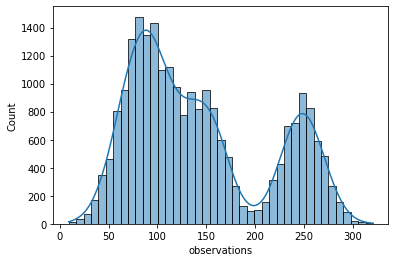

Total number of observations: 3314739 in the past 7 days.


In [312]:
print(observations.observations.describe())

sns.histplot(x = 'observations', data = observations, kde=True)
plt.show()

print('Total number of observations:', observations.observations.sum(), 'in the past 7 days.')

### Summary

To summarize the findings of this EDA, I outline below the chief characteristics of both datasets.

#### `species`
- Has 4 variables: category (the species taxonomy), scientific_name, common_names and conservation_status.
- All variables are either categorical or nominal.
- The data shows observations for 5541 unique species among 7 types, having 5504 common names and displaying 5 conservation statuses.

#### `observations`
- Has 3 variables: scientific_name, park_name and number of observations in the past 7 days.
- The variables are nominal, categorical and numerical respectively.
- The data shows 23296 entries of 5541 unique species documented in 4 parks in a total of 3314739 observations in the past 7 days.

## Analysis

For this analysis, I'll attempt to answer the questions stated above by beginning with the `species` dataset. 

### Q: What is the distribution of conservation status for animals?

First, I'll explore the distribution of animal categories among conservation statuses by grouping the `species` dataset by both columns and calculating the absolute and relative frequencies by conservation status. Then, I'll plot them below.

The most endangered animals in the dataset were mammals (6) and birds (4), while the only animal in recovery are birds (3), which could point to the fact that birds are recovering better than other animals.

The distribution of species among categories and conservation statuses is depicted in the following plot.

Total species under protection: 178
Total species not under protection: 5363


'Absolute frequencies'

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,6.0,0.0,0.0,1.0
In Recovery,0.0,3.0,0.0,0.0,0.0,0.0,0.0
Species of Concern,4.0,68.0,4.0,22.0,5.0,5.0,43.0
Threatened,2.0,0.0,3.0,2.0,0.0,0.0,2.0


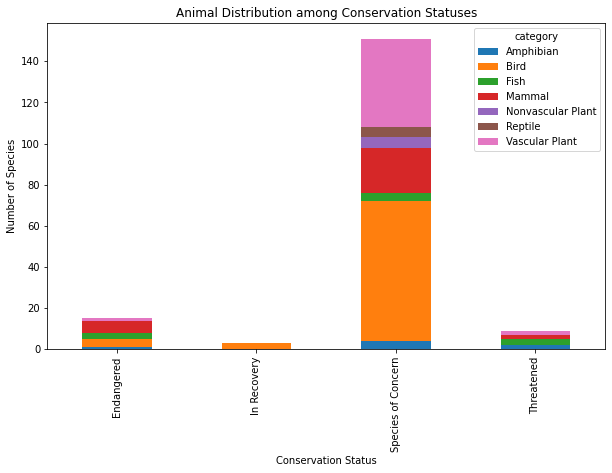

<Figure size 432x288 with 0 Axes>

In [324]:
num_conservation = len(species[species.conservation_status != 'No intervention'])
num_not_conservation = len(species[species.conservation_status == 'No intervention'])

print(f'Total species under protection: {num_conservation}')
print(f'Total species not under protection: {num_not_conservation}')

category_conservation = species[species.conservation_status != 'No intervention']\
                        .groupby(['conservation_status', 'category'])['scientific_name']\
                        .count()\
                        .unstack()\
                        .replace('nan', np.nan).fillna(0)

display("Absolute frequencies", category_conservation)

ax = category_conservation.plot(kind='bar', figsize=(10,6), stacked = True)
ax.set_xlabel('Conservation Status')
ax.set_ylabel('Number of Species')
plt.title("Animal Distribution among Conservation Statuses")
plt.show()
plt.clf()


In addition to that, the relative frequencies per conservation status reveal more information about the distribution of animal categories per status. 
- Mammals, birds and fish make up more than 85% of all endangered species documented in the `species` dataset. 
- More than 70% of species of concern are made up of birds and vascular plants. 
- As observed before, birds make up 100% of the species in recovery according to the dataset. 

These proportions can be clearly visualized in the plot below.

In [195]:
category_conservation_rel = species[species.conservation_status != 'No intervention']\
                            .groupby(['category', 'conservation_status'])['scientific_name']\
                            .count()\
                            .unstack()\
                            .replace('nan', np.nan).fillna(0)\
                            .apply(lambda x:  (100*x / x.sum()).round(2))\
                            .transpose()
display("Relative frequencies by category", category_conservation_rel)

'Relative frequencies by category'

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,6.67,26.67,20.00,40.00,0.00,0.00,6.67
In Recovery,0.00,100.00,0.00,0.00,0.00,0.00,0.00
Species of Concern,2.65,45.03,2.65,14.57,3.31,3.31,28.48
Threatened,22.22,0.00,33.33,22.22,0.00,0.00,22.22


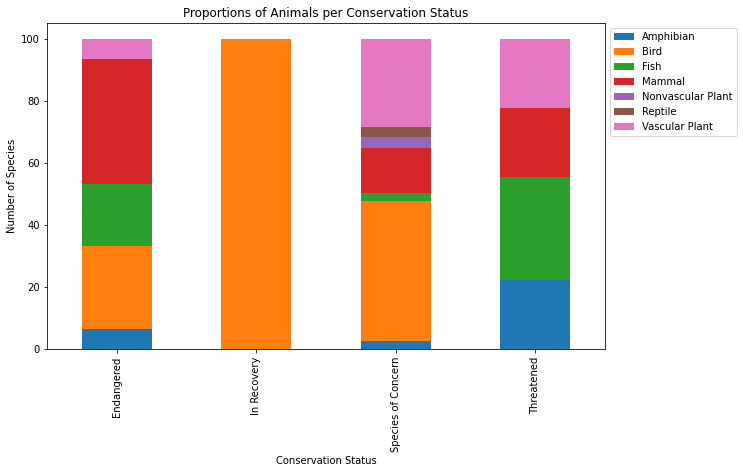

<Figure size 432x288 with 0 Axes>

In [196]:
axrel = category_conservation_rel.plot(kind='bar', figsize=(10,6), stacked = True)
axrel.set_xlabel('Conservation Status')
axrel.set_ylabel('Number of Species')
axrel.legend(bbox_to_anchor=(1,1), loc = 'upper left')
plt.title("Proportions of Animals per Conservation Status")
plt.show()
plt.clf()

### Q: Are certain types of species more likely to be endangered?

The next question concerns the relation between species and their conservation status. To answer this question, I'll group the conservation statuses into those reflecting some kind of intervention and those without. No intervention will become a marker for risk of endangerment.

After this I'll group the species categories and calculate the amount protected and not protected.

In [197]:
species['protected'] = species.conservation_status != 'No intervention'

category_protections = species.groupby(['category', 'protected'])\
                        .scientific_name.nunique()\
                        .reset_index()\
                        .pivot_table(columns = 'protected',
                                    index = 'category',
                                    values = 'scientific_name')\
                        .reset_index()
category_protections.columns = ['category', 'not_protected', 'protected']

category_protections['percentage_protected'] = (category_protections.protected / \
                                                (category_protections.protected + category_protections.not_protected) * 100)\
                                                .round(2)
display(category_protections)

,category,not_protected,protected,percentage_protected
0,Amphibian,72,7,8.86
1,Bird,413,75,15.37
2,Fish,115,10,8.00
3,Mammal,146,30,17.05
4,Nonvascular Plant,328,5,1.50
5,Reptile,73,5,6.41
6,Vascular Plant,4216,46,1.08


With this information, we can now visualize the percentages of protection for each species category. Based on this, mammals and birds display the highest proportion of protection with roughly 17% and 15% under protection, respectively. Thus, these species types are the most likely to be endangered among categories. The bar chart below visualizes the percentages per category.

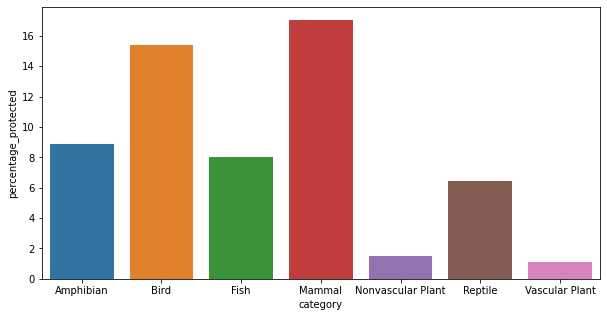

<Figure size 432x288 with 0 Axes>

In [198]:
plt.figure(figsize=(10,5))
sns.barplot(data = category_protections, y = 'percentage_protected', x = 'category')
plt.show()
plt.clf()

### Q: Are the differences between species and their conservation status significant?

The question of statistical significance for categorical variables is answered in statistics by use of the chi-square test. 

Since crosstabulating both variables would yield a complex result, it's better to break down the question into pairs of species categories. Since based on the previous question mammals are the most protected category, I'll compare the significance of other category differences with mammals. 

I'll start by permutating the pairs of categories with mammals. Then I'll loop over this list to perform the chi-square tests for each pair and plot the p-values to find the statistically significant differences among category pairs.


,Animal Pair,p-value
0,Bird,68.76
2,Amphibian,12.76
1,Reptile,3.84
3,Fish,3.52
4,Vascular Plant,0.00
5,Nonvascular Plant,0.00


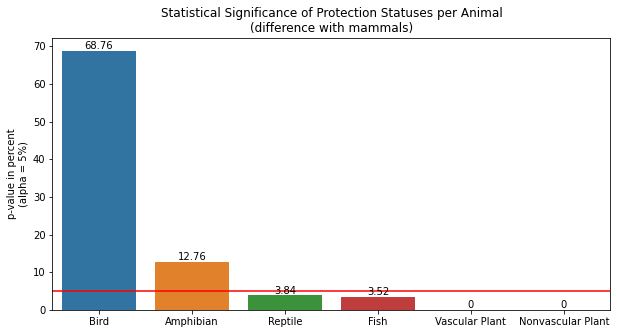

In [199]:
from scipy.stats import chi2_contingency

# Permutations
categories = list(species.category.unique())
combinations_mammal = [['Mammal', i] for i in categories][1:]
category_protections_part = category_protections.iloc[:, 0:3]
category_protections_part = category_protections_part.set_index('category')

# Significant Differences Data
sign_data = {'Animal Pair': [], 'p-value': []}
for pair in combinations_mammal:
    contingency_table = pd.DataFrame({pair[0]: category_protections_part.loc[pair[0]],
                                    pair[1]: category_protections_part.loc[pair[1]]}) 
    chi2, pval, dof, expected = chi2_contingency(contingency_table)
    sign_data['Animal Pair'].append(pair[1])
    sign_data['p-value'].append((pval*100).round(2))
sign_data = pd.DataFrame(data = sign_data).sort_values('p-value', ascending=False)
display(sign_data)

# Plot
plt.subplots(figsize=(10,5))
ax =sns.barplot(data = sign_data, x = 'Animal Pair', y = 'p-value')
plt.title('Statistical Significance of Protection Statuses per Animal\n(difference with mammals)')
plt.axhline(5, color='red')
ax.set_xlabel("")
ax.set_ylabel('p-value in percent\n(alpha = 5%)')
# plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.show()


The above graph illustrates the p-values for the chi-square tests performed for each animal category against mammals. Given an alpha of 5%, the analysis shows that birds and amphibians display no statistically significant differences in their conservations statuses compared to mammals. However, all other categories such as reptiles, fishes and plants show statistically significant differences in their conservation statuses when comapred to mammals. 

### Q: Which species were spotted the most at each park?

This final section will concern the second dataset, `observations`, to quantify the amount of observations per species in each of the parks listed. 

Since the dataset doesn't include common names, I'll use the `species` dataset to merge these names into the `observations` dataset. Then, I'll group the data by park and by species/common names, and sum their observations to rank the most spoted species per park.

In [308]:
merged_df = observations.merge(species[['category', 'scientific_name', 'common_names']], how='left')
merged_df = merged_df.drop_duplicates()

merged_df_grouped = merged_df.groupby(['park_name', 'scientific_name', 'common_names', 'category']).observations\
                        .sum().sort_values(ascending=False)\
                        .reset_index()
display(merged_df_grouped.head())

,park_name,scientific_name,common_names,category,observations
0,Yellowstone National Park,Holcus lanatus,"Common Velvet Grass, Velvetgrass",Vascular Plant,805
1,Yellowstone National Park,Puma concolor,Panther (Mountain Lion),Mammal,753
2,Yellowstone National Park,Procyon lotor,"Common Raccoon, Raccoon",Mammal,745
3,Yellowstone National Park,Hypochaeris radicata,"Cat's Ear, Spotted Cat's-Ear",Vascular Plant,726
4,Yellowstone National Park,Columba livia,Rock Dove,Bird,722


The previous table shows the number of observations for each species, grouped by park. To answer the question above, I'll create a table with the max value of observations per park, to show the species that was most spotted in each of the parks.

In [307]:
merged_df_grouped_max = merged_df_grouped.loc[merged_df_grouped\
                                                    .groupby(['park_name'])\
                                                    ['observations'].idxmax()]\
                                                .sort_values(by = 'observations', ascending=False)
display(merged_df_grouped_max)

,park_name,scientific_name,common_names,category,observations
0,Yellowstone National Park,Holcus lanatus,"Common Velvet Grass, Velvetgrass",Vascular Plant,805
112,Yosemite National Park,Hypochaeris radicata,"Cat's Ear, Spotted Cat's-Ear",Vascular Plant,505
298,Bryce National Park,Columba livia,Rock Dove,Bird,339
2402,Great Smoky Mountains National Park,Streptopelia decaocto,Eurasian Collared-Dove,Bird,256


## Conclusions

This project successfully answered the question stated at the beginning of this report, regarding the distribution of species and their conservation statuses among the four parks. To better explain the data, different visualizations were used to depict the conclusions to be drawn from the analysis. 

Below is a summary of the answers to the questions posed at the start of the report:

- What is the distribution of conservation status for species?
  - 5363 species are not protected under some conservation status. Of the remaining 178, most species are under the status of *species of concern*, especially birds and vascular plants.
- Are certain types of species more likely to be endangered?
  - Mammals and birds have the highest proportion of protection, revealing their higher risk of endangerement compared to the other categories.
- Are the differences between species and their conservation status significant?
  - In a comparisson with mammals, species such as amphibians, reptiles, fishes, and plants showed statistically significant differences in conservation proportion. Birds however did not exhibit a significant difference.
- Which animal is most prevalent and what is their distribution amongst parks?
    - The most common species recorded was the common velvet grass, a vascular plant, in Yellowstome National Park, while the Dove was the most commonly observed species both in Bryce and Great Smoky Mountains National Parks. In Yosemite the most observed species was the cat's ear plant.